## Test if the calibration is doing what I expect

* check that the pedestals are reasonable, by making ped distributions from pixels outside the shower

In [23]:
from ctapipe.io.hessio import hessio_event_source
from ctapipe.utils import datasets
from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean, dilate
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
%matplotlib inline

In [9]:
cal = CameraCalibrator(None,None)

In [22]:
hists = {}

def process_pedestal(event, output=False):
    global hists

    for tel in event.dl0.tels_with_data:
        geom = CameraGeometry.guess(*event.inst.pixel_pos[tel], event.inst.optical_foclen[tel])
        im = event.dl1.tel[tel].image[0]

        # select pixels that are not signal and calculate means and std of them (they should be pedestals):
        mask = tailcuts_clean(geom, im, picture_thresh=14, boundary_thresh=7)
        mask = dilate(geom, mask)

        if output:
            print("evt:{:10d} tel: {:03d}/{:10.10s} mean: {:5.3f} std: {:5.3f}"\
                  .format(event.dl0.event_id, tel, geom.cam_id, 
                          im[~mask].mean(), im[~mask].std()))
        
        hist, ed = np.histogram(im[~mask], bins=80)

        if geom.cam_id in hists:
            hists[geom.cam_id][0] += hist
        else:
            hists[geom.cam_id] = [hist,ed]


In [26]:
hists = {} 
source = hessio_event_source(datasets.get_dataset('gamma_test_large.simtel.gz'))

for event in tqdm_notebook(source):
    cal.calibrate(event)
    process_pedestal(event)

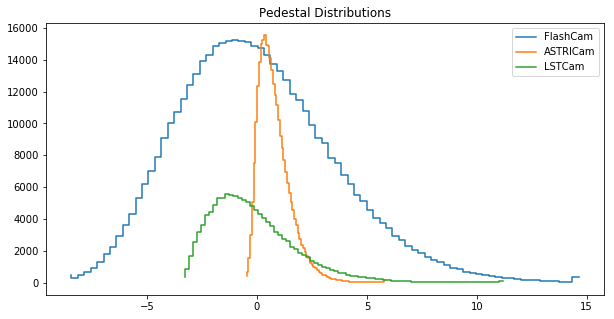

In [30]:
plt.figure(figsize=(10,5))
for cam in hists:
    plt.plot(hists[cam][1][1:], hists[cam][0], label=cam, ls='steps')
plt.legend()
plt.title("Pedestal Distributions")